# Predict Magnetic Structure

In [1]:
import re
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyhf3.read import ReadInfo
from pyhf3 import draw
from pyhf3 import magstr

In [58]:
name = 'baoso3'
path_input = 'input/%s/' % name
path_output = 'output/%s/' % name

info_path, info_cell = ReadInfo(path_input)

types = ['a', 'c', 'g']
types_dict = {'a':0, 'c':1, 'g':2}

figsize=(11, 6)
plt.rcParams.update({'font.size': 25})

"""
def DrawHeatmap(path_output, fn):
    df = pd.read_csv('%s/%s' % (path_output, fn))
    bins_range = sorted(list(set(df['bins'])))
    eta_range = sorted(list(set(df['eta'])))
    
    df = df.sort_values(by=['bins', 'eta'])
    data = df['acc'].to_numpy().reshape((len(bins_range), len(eta_range))).T
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ms = ax.matshow(data, cmap='Blues')
    cb = plt.colorbar(ms, shrink=0.9, format='%.2f')
    
    acc_max = 0
    coord = (0, 0)
    for (i, j), z in np.ndenumerate(data):
        #ax.text(j, i, '{:0.2f}'.format(z), size=13, ha='center', va='center', c='white')
        if z > acc_max:
            acc_max = z
            coord = (j, i)
            
    #ax.text(coord[0], coord[1], '{:0.2f}'.format(acc_max), size=13, ha='center', va='center', c='white')
    ax.scatter(coord[0], coord[1], s=150, c='white', marker='*')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(range(0, len(bins_range)))
    ax.set_yticks(range(0, len(eta_range)))
    ax.set_xticklabels(bins_range, rotation=45)
    ax.set_yticklabels(eta_range)
    ax.set_xlabel('Interval')
    ax.set_ylabel('Broadening scale')
    print(coord, acc_max)
    plt.show()
    
def DrawOptEta(path_output, fn, bins):
    df = pd.read_csv('%s/%s' % (path_output, fn))
    df = df[df['bins'] == bins]
    data = df[['eta', 'acc']].to_numpy()
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(data[:, 0], data[:, 1], '.-', ms=20)
    ax.grid(True)
    yticks = [i for i in np.arange(0.90, 0.97, 0.01)]
    ax.set_yticks(yticks)
    ax.set_yticklabels(['%.2f' % i for i in yticks])
    ax.set_xlabel('Broadening scale')
    ax.set_ylabel('Accuracy')
    plt.show()
"""

def DrawHist(df, title, params):
    bins = len(df.columns) - len(params)
    hist = df.drop(params, axis=1).sum()
    x = hist.index.to_list()
    
    xt = np.arange(0, len(x), bins//4, dtype=int)
    xt = np.append(xt, len(x)-1)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x, hist)
    ax.set_xticks([x[i] for i in xt])
    ax.set_title(title, loc='left')
    plt.show()

def DrawConfusionMatrix(y_test, y_pred, title):
    from sklearn.metrics import ConfusionMatrixDisplay
    
    fig, ax = plt.subplots(figsize=figsize)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues', values_format='.2f', ax=ax)
    ax.set_title(title, loc='left')
    plt.show()
    
def DrawROC(y_test, y_score, title):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    
    y_testb = label_binarize(y_test, classes=types)
    n_classes = y_testb.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_testb[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        ax.plot(fpr[i], tpr[i], label='%s (%.3f)' % (types[i], roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title, loc='left')
    ax.legend(loc="lower right")
    plt.show()
    
def DrawInput(df, title, prefix=''):
    alpha = 0.5
    bins0 = [len(np.unique(df['JU'])), len(np.unique(df['N']))//4, len(np.unique(df['U']))]
    xlim = [[-0.01, 0.31], [0, 12], [-0.1, 5.1]]
    
    for i, v in enumerate(['JU', 'N', 'U']):
        fig, ax = plt.subplots(figsize=figsize)
        _, bins = np.histogram(df[v], bins=bins0[i])
        for j, t in enumerate(types):
            df[df['type'] == j].hist(column=[v], ax=ax, bins=bins, alpha=alpha, label=t)
        ax.set_xlim(xlim[i])
        ax.legend()
        ax.set_title('%s%s\n'%(prefix,v)+title, loc='left')
        plt.title('')
    plt.show()

def DrawOutput(df, title, prefix='', zoom=False):
    bins0 = 50
    bins_ins0 = 20
    alpha = 0.5
    xlim = [[-0.1, 6.1], [], []]
    xlim_ins = [[-0.1, 1], [0, 10], [-0.1, 0.5]]
    
    for i, v in enumerate(['m', 'dntop', 'gap']):
        fig, ax = plt.subplots(figsize=figsize)
        _, bins = np.histogram(df[v], bins=bins0)
        for j, t in enumerate(types):
            df[df['type'] == j].hist(column=[v], ax=ax, bins=bins, alpha=alpha, label=t)

        if zoom:
            ins = ax.inset_axes([0.4,0.6,0.3,0.3])
            _, bins_ins = np.histogram(df[v], bins=bins_ins0)
            for j, t in enumerate(types):
                df[df['type'] == j].hist(column=[v], ax=ins, bins=bins_ins, alpha=alpha, label=t)
            ins.set_xlim(xlim_ins[i])
            ins.set_title('')
        if len(xlim[i]): ax.set_xlim(xlim[i])
        ax.legend()
        ax.set_title('%s%s\n'%(prefix,v)+title, loc='left')
        plt.title('')
    plt.show()
    
def DrawType(df, title, prefix=''):
    fig, ax = plt.subplots(figsize=figsize)
    
    df.hist(column=['type'], ax=ax)
    
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(types)
    ax.set_xlim([-0.1, 2.1])
    ax.set_ylim([0, 1800])
    ax.set_title('%stype\n'%(prefix)+title, loc='left')
    plt.title('')
    plt.show()
    
def DrawMisType(df, title):
    bins0 = len(types)
    alpha = 0.5
    
    fig, ax = plt.subplots(figsize=figsize)
    _, bins = np.histogram(df['type'], bins=bins0)
    for i, t in enumerate(types):
        df[df['type_f'] == i].hist(column=['type'], ax=ax, bins=bins, alpha=alpha, label=types[i])
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(types)
    ax.set_xlim([-0.1, 2.1])
    ax.legend()
    ax.set_title('misclassifed type\n'+title, loc='left')
    plt.title('')
    plt.show()
    
def DrawCorr(df):
    fig, ax = plt.subplots(figsize=figsize)
    corr = df.loc[:, ['JU', 'N', 'U', 'm', 'dntop', 'gap']].corr()
    sns.heatmap(corr, annot=True, fmt='.1f', ax=ax)
    plt.show()
    
def DrawImp(estimators, importances, feature_names):
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots(figsize=(25, 6))
    std = np.std([importances for tree in estimators], axis=0)
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
def DrawResult(ptype, pnum, dtype, tol, bins, eta, rsp):        
    # df_dos(input)
    df_dos = pd.read_csv('%s/magstr/dos_ptype%s_pnum%d_dtype%s_tol%.3f_bins%d_eta%.3f.csv'% (path_output, ptype, pnum, dtype, tol, bins, eta), sep=',', index_col=0)

    ms = magstr.MagStr(path_output, info_path, info_cell, ptype, pnum)
    acc, y_test, y_pred, y_score, y_idx, est, imp = ms.DoRandomForest(dtype, tol, bins, eta, rsp=rsp)

    # df_rsp
    df_rsp = df_dos.loc[y_idx, :]
    
    # df_mis
    mis_list = []
    f_list = []
    for i, y_true in enumerate(y_test):
        if(y_true != y_pred[i]):
            mis_list.append(y_test.index[i])
            f_list.append(y_pred[i])
    df_mis = df_dos.loc[mis_list, :]

    # add misclassified type at df_mis
    df_mis['type_f'] = 0
    for i, idx in enumerate(mis_list):
        df_mis.loc[idx, 'type_f'] = f_list[i]

    df_dos['type'] = df_dos['type'].replace(types_dict)
    df_rsp['type'] = df_rsp['type'].replace(types_dict)
    df_mis['type'] = df_mis['type'].replace(types_dict)
    df_mis['type_f'] = df_mis['type_f'].replace(types_dict)
    
    print('accuracy = %d/%d = %.4f' % ((len(y_pred)-len(df_mis)), len(y_pred), acc))

    return df_dos, df_rsp, df_mis, y_test, y_pred, y_score, ms.params, est, imp

accuracy = 809/816 = 0.9914


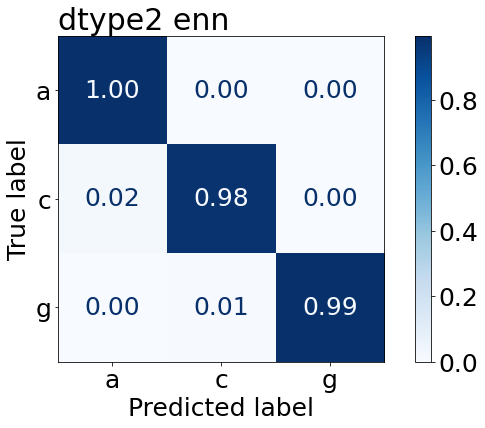

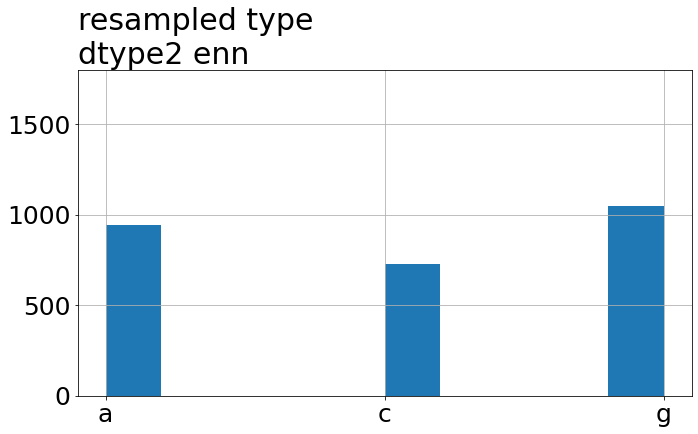

In [64]:
args = {
    'ptype':0,
    'pnum':0,
    'dtype':2,
    'tol':1.0,
    'bins':100,
    'eta':0.05,
    'rsp':'enn'
}

title = 'dtype%s %s' %\
(args['dtype'], args['rsp'])
prefix = 'resampled '

df_dos, df_rsp, df_mis, y_test, y_pred, y_score, params, est, imp =\
DrawResult(args['ptype'], args['pnum'], args['dtype'], args['tol'], args['bins'], args['eta'], args['rsp'])

if   prefix == 'resampled ':    df = df_rsp
elif prefix == 'misclassified ': df = df_mis
else:
    print('no prefix')
    df = df_dos

#print(len(df_dos))
#DrawHist(df_dos, title=title, params=params)
DrawConfusionMatrix(y_test, y_pred, title=title)
#DrawROC(y_test, y_score, title=title)
DrawType(df, title=title, prefix=prefix)
#DrawMisType(df_mis, title=title)
#DrawInput(df, title=title, prefix=prefix)
#DrawOutput(df, title=title, prefix=prefix, zoom=False)
#DrawImp(est, imp, [col for col in df_dos.columns.to_list() if not col in params])

In [ ]:
dr = draw.Draw(path_input, path_output, info_path, info_cell, 0.1, 0)
dr.DrawBandDOS('g', 6, 1, 1)
dr.DrawBandDOS('c', 6, 1, 1)

In [ ]:
lists = [(0, 0), (1, 10), (2, 10)]
dfs = []
dfms = []

tol = 1e-3
bins = 100
eta = 0.5

for (i, j) in lists:
    m = magstr.ML(path_output, info_path, info_cell, i, j)
    info = 'ptype%d num%d tol%.3f' % (i, j, tol)
    title = '%s bins%d eta%.1f' % (info, bins, eta)
    
    # df
    df, e_label, w_label, p_label = m.OpenBand(tol)
        
    # RF
    acc, y_test, y_pred, y_score = m.DoRandomForest(tol, bins, eta)
    print(acc)
    
    # dfm
    mis_list = []
    f_list = []
    for i, y_true in enumerate(y_test):
        if(y_true != y_pred[i]):
            mis_list.append(y_test.index[i])
            f_list.append(y_pred[i])
    dfm = df.loc[mis_list, :]
    
    # add False type at dfm
    dfm['type_f'] = 0
    for i, idx in enumerate(mis_list):
        dfm.loc[idx, 'type_f'] = f_list[i]
    
    df['type'] = df['type'].replace(types_dict)
    dfm['type'] = dfm['type'].replace(types_dict)
    dfm['type_f'] = dfm['type_f'].replace(types_dict)
    
    dfs.append([df, e_label, w_label, p_label, title])
    dfms.append([dfm, y_test, y_pred, title])

    DrawHist(df, e_label, info)
    DrawROC(y_test, y_score, title=title)
    DrawConfusionMatrix(y_test, y_pred, title=title)

In [ ]:
print(dfs[0][1])

In [ ]:
DrawInput(dfs[0][0], '')
DrawOutput(dfs[0][0], '')

In [ ]:
corr = dfs[0][0].loc[:, ['JU', 'N', 'U', 'm', 'dntop', 'gap']].corr()
sns.heatmap(corr, annot=True, fmt='.1f')

In [ ]:
for i in range(3):
    DrawMisType(dfms[i][0], dfms[i][-1])
    #DrawInput(dfms[i][0], dfms[i][-1])
    DrawOutput(dfms[i][0], dfms[i][-1])

In [ ]:
for i in range(3):
    df = dfms[i][0]
    print(df[df['m'] > 3.0])

In [ ]:
d = []
for i in range(4):
    di = draw.Draw(path_input, path_output, info_path, info_cell, 0.1*i, 0)
    d.append(di)

In [ ]:
d[0].DrawBandDOS('a', 8.0, 3.5)
d[0].DrawBandDOS('c', 8.0, 3.5)
d[0].DrawBandDOS('g', 8.0, 3.5)

In [ ]:
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        if j != i:
            df = dfms[0][0][(dfms[0][0]['type'] == i) & (dfms[0][0]['type_f'] == j)]
            print('type %d type_f %d' % (i, j), len(df), sep='\n')

In [ ]:
dfca = dfms[0][0][(dfms[0][0]['type'] == 1) & (dfms[0][0]['type_f'] == 0)]
DrawInput()

In [ ]:
DrawHist(0)
DrawHist(1)
DrawHist(2)

In [ ]:
plt.rcParams.update({'font.size': 18})

DrawHeatmap(path_output, 'magstr/acc_rf.csv')

In [ ]:
plt.rcParams.update({'font.size': 18})

DrawOptEta(path_output, 'magstr/acc_rf.csv', 40)

In [ ]:
plt.rcParams.update({'font.size': 16})

acc, y_test, y_pred = m.DoRandomForest(100, 0.4)
DrawConfusionMatrix(y_test, y_pred)

In [ ]:
y_test.iloc[0]

In [ ]:
df0, e_label, w_label, p_label = m.OpenBand()
mis_list = []
cor_list = []

for i, y_true in enumerate(y_test):
    if(y_true != y_pred[i]):
        mis_list.append(y_test.index[i])
    else:
        cor_list.append(y_test.index[i])
        
df_mis = df0.loc[mis_list, :]
df_cor = df0.loc[cor_list, :]
df_mis

In [ ]:
df_mis = df_mis.sort_values(by=['N', 'U'])
df_mis[p_label]